# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Aldazia Green

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [4]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [5]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

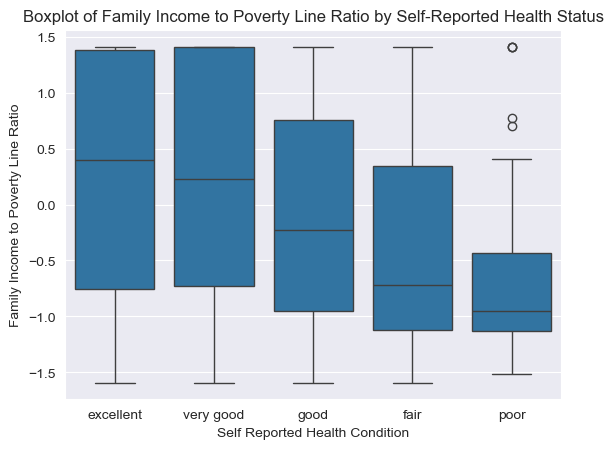

In [8]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

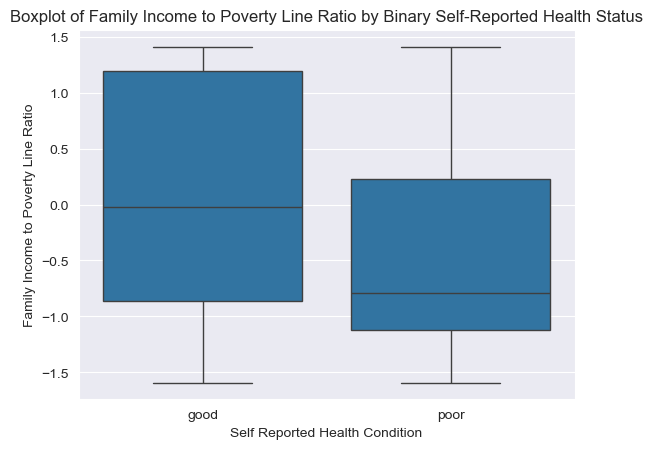

In [9]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

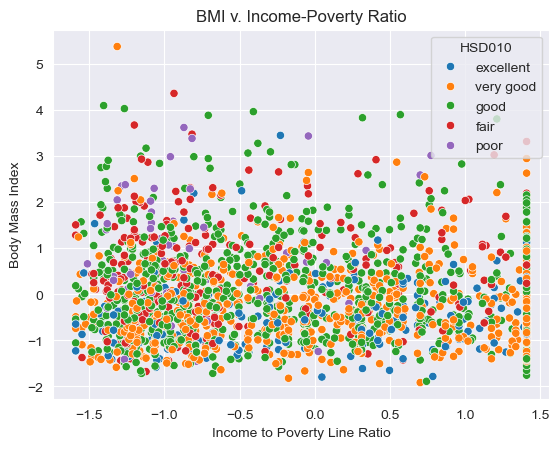

In [11]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [13]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [17]:
## 
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)


### In this step, I selected 4 components initailly as I reflect on the combination of responses to HSD010.  Reflecting on the responses it can be reasonable that individuals who report their health as very good and good are more similar compared to other classfication groups. Therefore 4 components can be created in this first PCA anlysis to determine the feature differences across  excellent, fair, poor, and "good/very good" individuals. 

In [19]:
pca_nhanes = pd.DataFrame(data = principalComponents_nhanes_scaled, 
                      columns = ['principal component 1', 
                                 'principal component 2','principal component 3','principal component 4'])

In [20]:
pca_nhanes.head(10)

,principal component 1,principal component 2,principal component 3,principal component 4
0,9.527811,-0.816224,-1.867078,-2.109500
1,-5.838338,-3.692573,3.805780,-1.030252
2,-0.719454,-2.573200,0.907842,-4.757516
3,3.533627,-2.576984,-3.249024,-0.404248
4,-6.872094,-4.194241,0.886808,-0.849030
5,9.658237,-0.753907,-3.817939,1.951038
6,-5.721710,-3.652449,0.148273,1.479564
7,-0.393310,5.374272,-2.949038,0.475777
8,-0.001068,-2.386482,-3.176893,1.137893
9,4.168626,-2.171785,-0.874223,-4.013292


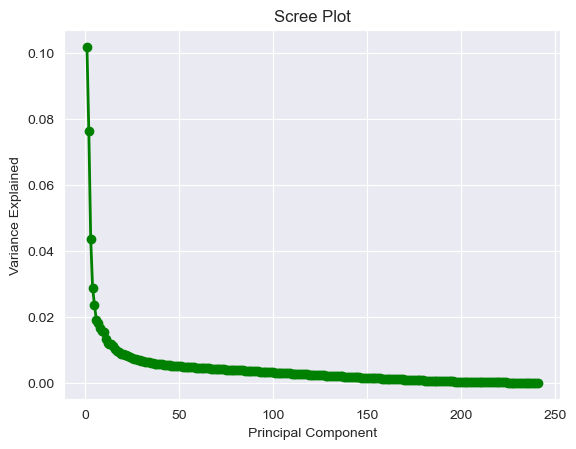

In [21]:
# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_breast = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
#The scree plot reveals a big drop between principal component 0-50.
#However we also see this drop near 0.02 variance, which can inform our cut off  variance variance value for how much a princoal component should explain.


### Barplot of Components

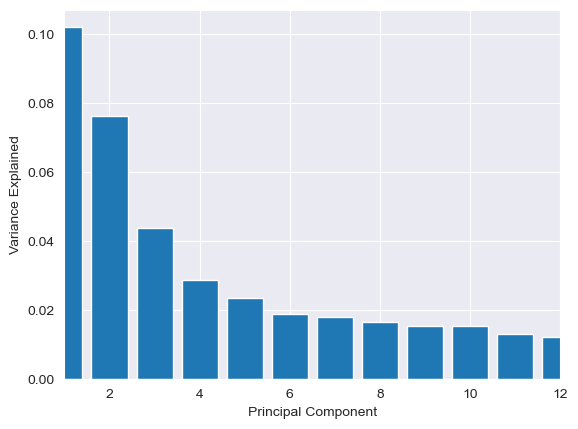

In [23]:
plt.bar(PC_values, pca_all.explained_variance_ratio_)

plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(1,12)
plt.show()
# Using 0.02 as our cut off (due to the immense clustering of data we seen at this point in the screeplot), 
#principal components 1-5 have a variance value greater than 0.02.
#We should include these in our Supervised learning model. 

### How many components will you use to fit a supervised learning model?

## From the PCA analysis above, it appears that we should actually fit our model to 5 principal components rather than 4. Findings from both the scree plot and bar plot, indicate a drop off of diminishing returns approximately after 5 prinicpal components. It is interesting that this number aligns with the 5 categorical answers for 'HSD010' 

### 2D Scatterplot of the first two components

In [27]:
## 
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled_columns =nhanes_scaled.columns

In [28]:
print ('Columns of Scaled Nhanes Data',nhanes_scaled_columns)

Columns of Scaled Nhanes Data Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [29]:
pca.columns = pca_nhanes.columns
print ('PCA columns', pca_nhanes.columns)

PCA columns Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4'],
      dtype='object')


In [30]:
print(hsd010)

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64


In [31]:
hsd010 = hsd010.replace([1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
print(hsd010)

0       excellent
1       excellent
2       very good
3       very good
4            good
          ...    
2059         good
2060    very good
2061         fair
2062    excellent
2063    very good
Name: HSD010, Length: 2064, dtype: object


<Figure size 640x480 with 0 Axes>

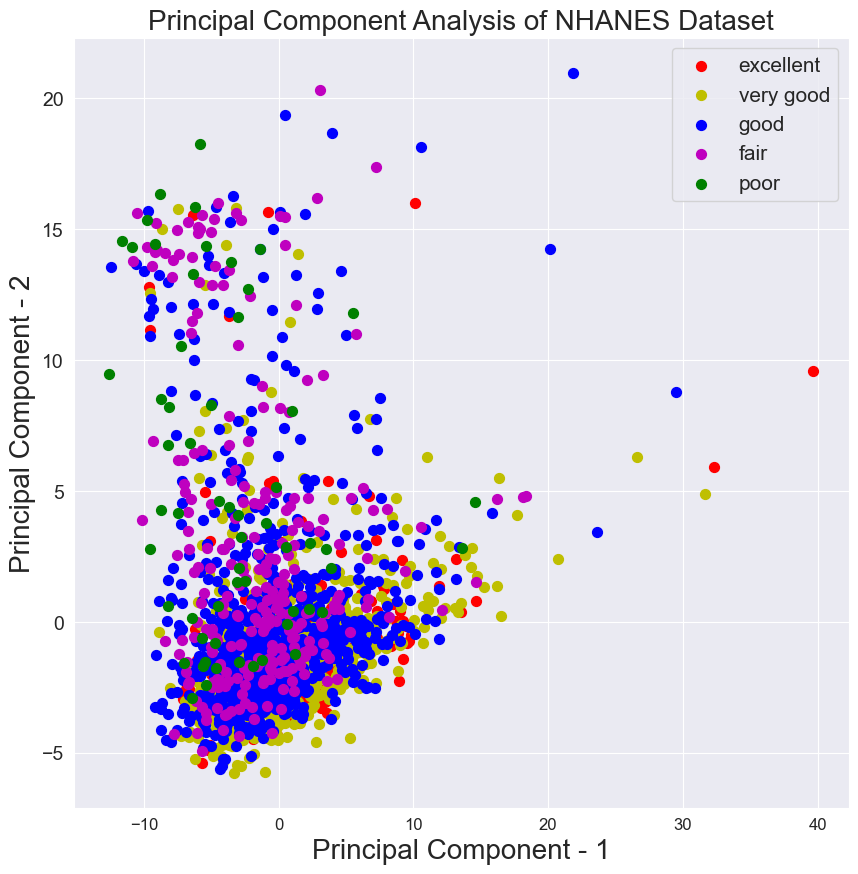

In [32]:
# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'y','b','m', 'g']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    plt.scatter(pca_nhanes.loc[indicesToKeep, 'principal component 1']
               ,pca_nhanes.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

## Using the first two components, notice the data is extremely clustered in the lower left quadrant of the graph. Furthermore, with only two components intrepreting differences between the those who have good, fair, excellent, poor,and very good is difficult. While the respondents on the far right of the graph appear to be outliers in this graph, perhaps their  individual variance can not be explained simply just two principal components. 

In [34]:
from sklearn.decomposition import PCA
pca_five = PCA(n_components=5)
principalComponents_Nhanes_scaled = pca_five.fit_transform(nhanes_scaled)


In [35]:
pca_Nhanes = pd.DataFrame(data = principalComponents_Nhanes_scaled, 
                      columns = ['principal component 1', 
                                 'principal component 2','principal component 3','principal component 4','principal component 5'])
pca_Nhanes.head(10)
#New pca_NHanes data frame with five principal components that should be used going foward.

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,9.602745,-0.840786,-1.911785,-2.209908,-3.929466
1,-5.727098,-3.882821,3.737343,-1.298073,0.396930
2,-0.660008,-2.645057,0.864971,-4.791695,-1.801860
3,3.585217,-2.587791,-3.249476,-0.395830,4.000426
4,-6.843639,-4.236588,0.903892,-0.784658,-0.527141
5,9.728331,-0.766461,-3.836848,1.834639,9.892444
6,-5.702858,-3.672899,0.181176,1.536517,-1.923731
7,-0.368773,5.217390,-3.035991,0.232138,-1.472929
8,0.005272,-2.353468,-3.138395,1.249856,1.059130
9,4.218437,-2.182001,-0.897301,-3.982740,-2.348911


## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Clustering Algorithm: K-Means

In [39]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')

In [40]:
# create an array of points
X = nhanes_scaled

In [41]:
df = pd.DataFrame(X)
nhanes_scaled_columns = X.columns
print ('Columns of Scaled Nhanes Data',nhanes_scaled_columns)

Columns of Scaled Nhanes Data Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [42]:
X = df 

In [43]:
# set random seed
np.random.seed(10)

In [44]:
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(X)


### I selected four clusters as it aligned with my initial exploration of PCA analysis. I will begin with 4 clusters for the Kmeans clustering approach because I will group very good and good responses into one category.

In [46]:
# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(X, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.00000000e+00  2.31208932e-04  0.00000000e+00  3.14428469e-02
   1.66023352e-01 -1.95211590e-02 -1.40913673e-02  1.12419229e-02
   3.08274981e-03 -3.52923722e-02  7.82792101e-02 -2.53543624e-02
   5.29049024e-02  4.98639093e-01  1.37494175e+00  1.16765970e+00
   1.11151618e+00  7.92860602e-01  8.15388022e-01  1.32219498e+00
   1.28672608e+00  1.25384615e+00  1.02071883e+00  8.87082605e-01
   8.04280897e-01  9.44462084e-01  7.67703443e-01  2.55253562e-01
   2.69277878e-01  1.04630852e+00  1.06608249e+00  9.79749736e-01
   8.21347940e-01  9.18330701e-01  5.97178263e-01  8.43976914e-01
   8.39511085e-01  1.02954957e+00  8.64303349e-01  3.50380475e-01
   6.25506564e-01  4.04953647e-01  1.11092130e+00  1.30765906e+00
   1.06625696e+00  9.84448839e-01  1.06240068e+00  9.68845066e-01
   1.15768874e+00  1.12185812e+00  1.08992545e+00  5.23716748e-01
   8.44983877e-01  8.79372239e-01  8.66601781e-01  9.49880711e-01
   5.97667502e-01  1.01959229e+00  1.29570112e+00  1.26238090e+00
  

In [47]:
kmeans_labels = kmeans.labels_
centers = kmeans.cluster_centers_

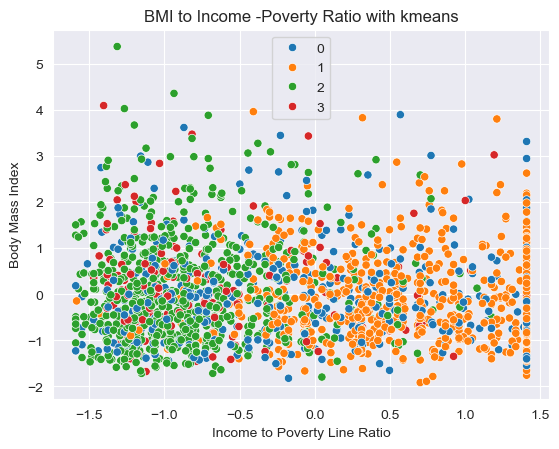

In [48]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = kmeans_labels, palette = "tab10", data = X)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI to Income -Poverty Ratio with kmeans")
plt.show()

## Plot your clusters on top of the BMI v. Income Poverty Ratio Plot¶
#### Notice how you can not identify specific (dis)similarities across the clusters in the graph. You can not tell when one cluster begins or when one cluster ends 

## Without the Clusters :

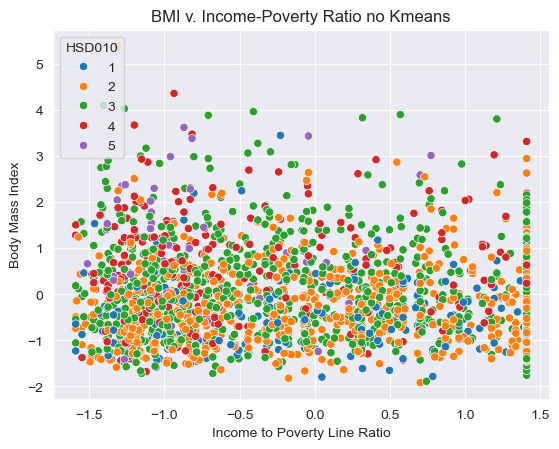

In [51]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio no Kmeans")
plt.show()

### Notice how one can not easily distinguish between classification of individuals with similar features. There are no difference across BMI and income/poverty ratio can be observed across inidviduals who identified in similar ways to to the HSD010 question.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [54]:
# set random seed
np.random.seed(10)
kmeanss = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_Nhanes)

In [55]:
# print the centers 
print("Centers")
print(kmeanss.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(pca_Nhanes, kmeanss.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 7.07518236  0.74169328  0.78286607  0.11035929 -0.22233757]
 [-0.41329996 -1.99858388 -2.27934749 -0.1095797  -0.10564474]
 [-4.263609   11.6790318  -1.63881066 -2.10735729 -0.15081832]
 [-2.8645953  -0.77983577  2.89586256  0.60117366  0.31645144]]

Labels
[0 2 1 ... 2 0 1]

Coordinates: principal component 1 Label: 0
Coordinates: principal component 2 Label: 3
Coordinates: principal component 3 Label: 1
Coordinates: principal component 4 Label: 1
Coordinates: principal component 5 Label: 3


In [56]:
pcakmeans_labels = kmeans.labels_
pcacenters = kmeans.cluster_centers_

In [57]:
pca_Nhanes.columns

Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4',
       'principal component 5'],
      dtype='object')

In [58]:
kmeans_labels_df= pd.DataFrame(pcakmeans_labels)

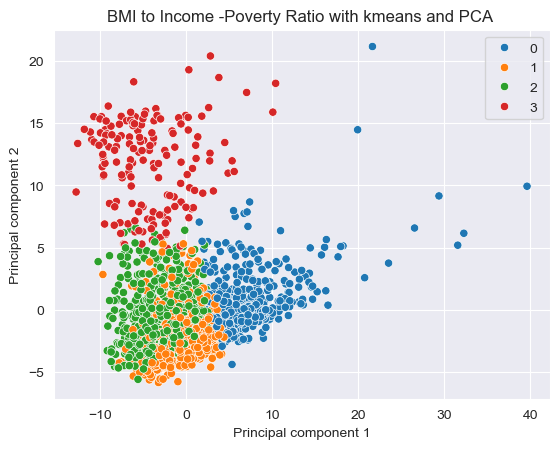

In [59]:
ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = pcakmeans_labels, palette = "tab10", data = pca_Nhanes)
ax.set(xlabel = "Principal component 1",
      ylabel = "Principal component 2")
ax.set_title("BMI to Income -Poverty Ratio with kmeans and PCA ")
plt.show()

### When the Clustering algorithm was retrained on PCA components, we can now notice trends across the dataset using these summarized feature components.The 4 distinct clusters is more identifiable in comparison to when the Kmeans was first intialized. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [65]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# Sklearn libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

# Keras libraries
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [66]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')

In [67]:
hsd010.unique()

array([1, 2, 3, 4, 5])

In [68]:
hsd010

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64

In [69]:
# Create a binary version of hsd010 where 1-3 are "good/0" and 4-5 are "poor/1"
nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010'].replace( [1, 2, 3, 4, 5], [0, 0, 0, 1, 1]) 

In [70]:
nhanes_scaled['HSD010_binary']

SEQN
73568    0
73576    0
73579    0
73581    0
73584    0
        ..
83694    0
83696    0
83704    1
83716    0
83721    0
Name: HSD010_binary, Length: 2064, dtype: int64

In [71]:
HSD010_binary = nhanes_scaled['HSD010_binary']

In [72]:
#nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(['good', 'good', 'good', 'poor', 'poor'][1, 2, 3, 4, 5],) 

In [73]:
# partition data
# -----------
y = HSD010_binary # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010_binary'],axis =1)# drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [74]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
num_classes = y_test.shape[1]

In [75]:
model = Sequential()

In [76]:
X_train.shape

(1548, 242)

In [77]:
y_train.shape

(1548, 2)

In [78]:
#Input layer 
model.add(  
    Dense(y_train.shape[1],                   # specify the number of neurons
          input_dim = X_train.shape[1],         # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
#Output 

model.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)


## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 0s - 38ms/step - accuracy: 0.7797 - loss: 0.6896 - val_accuracy: 0.8488 - val_loss: 0.6844
Epoch 2/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6813 - val_accuracy: 0.8488 - val_loss: 0.6745
Epoch 3/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6714 - val_accuracy: 0.8488 - val_loss: 0.6625
Epoch 4/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6587 - val_accuracy: 0.8488 - val_loss: 0.6476
Epoch 5/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6420 - val_accuracy: 0.8488 - val_loss: 0.6292
Epoch 6/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6210 - val_accuracy: 0.8488 - val_loss: 0.6066
Epoch 7/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5959 - val_accuracy: 0.8488 - val_loss: 0.5811
Epoch 8/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5695 - val_accuracy: 0.8488 - val_loss: 0.5556
Epoch 9/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5433 - val_accuracy: 0.8488 - val_loss: 0.5320
Epoch 10/10
8/8 - 0s - 2ms/step - ac

### Results above show that as more data is fed back into the network, validation accuracy scores remains the same . Howver the overall accuracy remains to be 0.8359 after the first epoch was fed more information. However as the network expands, the loss function decreases which is a good indication for a well-fit model. 

##  Neural Network on  Principal Components 

In [82]:
y=HSD010_binary
X =pca_nhanes

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [84]:
num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
num_classes = y_test.shape[1]

In [85]:
model_two = Sequential()

In [86]:
model_two.add(  
    Dense(y_train.shape[1],                   # specify the number of neurons
          input_dim = X_train.shape[1],         # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
model_two.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)


## Add any additional layers you wish here

model_two.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model_two.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 0s - 32ms/step - accuracy: 0.8359 - loss: 0.6813 - val_accuracy: 0.8488 - val_loss: 0.6759
Epoch 2/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6720 - val_accuracy: 0.8488 - val_loss: 0.6662
Epoch 3/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6622 - val_accuracy: 0.8488 - val_loss: 0.6558
Epoch 4/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6517 - val_accuracy: 0.8488 - val_loss: 0.6448
Epoch 5/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6404 - val_accuracy: 0.8488 - val_loss: 0.6333
Epoch 6/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6286 - val_accuracy: 0.8488 - val_loss: 0.6210
Epoch 7/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6163 - val_accuracy: 0.8488 - val_loss: 0.6082
Epoch 8/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6032 - val_accuracy: 0.8488 - val_loss: 0.5950
Epoch 9/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.5898 - val_accuracy: 0.8488 - val_loss: 0.5814
Epoch 10/10
8/8 - 0s - 2ms/step - ac

### When PCA components are added to the neural network we see that the overall accuracy remains to be 0.8359 repeatedly.Additionally the validation accuracy scores remains the same at 0.8448. However, we see changes in the loss function. Using PCA components, the loss function begins at 0.6904 and ends at 0.6211 ( difference of 0.0693). However, in the first iteration without PCA components the loss function went from 0.6900 to 0.5143 ( difference of 0.1757). Therefore we can see the  loss function range differ across the two neural network iterations. 

### Neural Network on  Principal Components + Cluster Membership

In [90]:
## 
y=HSD010_binary
X = kmeans_labels_df

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [92]:
num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
num_classes = y_test.shape[1]

In [93]:
X_train.shape

(1548, 1)

In [94]:
y_train.shape

(1548, 2)

In [95]:
model_three = Sequential()

In [96]:
#Input layer 
model_three.add(  
    Dense(y_train.shape[1],                   # specify the number of neurons
          input_dim = X_train.shape[1],         # specify the input shape
          kernel_initializer='normal',  # specify method for initializing weights - follows Gaussian distribution
          activation='relu')            # specify activation function
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
#Output 

model_three.add(
    Dense(num_classes,                 # specify the number of output units,
          kernel_initializer='normal', # specify method for initializing weights - follows Gaussian distribution
          activation='softmax')        # specify activation function - softmax turns output to probabilities
)


## Add any additional layers you wish here

model_three.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model_three.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 0s - 33ms/step - accuracy: 0.6040 - loss: 0.6923 - val_accuracy: 0.8488 - val_loss: 0.6887
Epoch 2/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6863 - val_accuracy: 0.8488 - val_loss: 0.6827
Epoch 3/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6806 - val_accuracy: 0.8488 - val_loss: 0.6770
Epoch 4/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6753 - val_accuracy: 0.8488 - val_loss: 0.6716
Epoch 5/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6702 - val_accuracy: 0.8488 - val_loss: 0.6664
Epoch 6/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6653 - val_accuracy: 0.8488 - val_loss: 0.6612
Epoch 7/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6604 - val_accuracy: 0.8488 - val_loss: 0.6562
Epoch 8/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6556 - val_accuracy: 0.8488 - val_loss: 0.6513
Epoch 9/10
8/8 - 0s - 2ms/step - accuracy: 0.8359 - loss: 0.6509 - val_accuracy: 0.8488 - val_loss: 0.6464
Epoch 10/10
8/8 - 0s - 2ms/step - ac

### In this last neural network example using both PCA and Kmeans clustering results, we see that again the overal accuraccy and validation scores remain to be the same as the first two iterations of this supervised learning approach. However, again we see a change in loss function values such that in this approach we see a change in loss from 0.6897 to 0.6318 (difference of 0.0579). 
### Reflections from using neural networks : As illustarted, the different combination of supervised ( i.e Neural Network) and unsupervised learning approaches (i.e PCA and Clustering) we can notice a decrease in loss function as we add more unsupervised techniques. However these combinations do not necessarily impact the overall accuracy of the neural network. This poses the question for myself to wonder if combination techniques from this notebook helps with increasing model accruacy or only for minimizing  loss functions.  PCA and cluster membership is great for interpretability and identifying similar features, using these components in a neural network approach can result in an minimizing loss functions. This result in our  model predicting y values closer to  our actual y. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

### PCA exracts summarized feature dimensions from a dataset and creates an orthogonal system of uncorrelated features. In this process, we can reduce our chance at collinearity across features and also aid interpretability. This can be particularlly helpful for social science research questions that requires grouping of interrelated features(such as family income, poverty,SES, etc.) Clustering could be used to group features based on simialrity in a high dimensional outcome space. In the example above, we can see how clustering techniques can be used to identify particular classes within the BMI v. Income Poverty Ratio clustered scatterplt. 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## The advantages of using both PCA and clustering involves a reduction in loss function which minimizes the prediction error of our model. In the clustering approach we see that , more similarities are observed across the sample when we retrain the algorithm on just pca summarized features. Advantages of using both PCA and clustering includes having that birds eye view of the data, which allows one to  identify common similarities across a largre amount of features that align with the individual characteristics of your sample. However, it is interesting to see that when PCA & Kmeans & Neural Networks was used  validation accuracy and overall estimated accuracy of these models did not change as much.  


3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

### Usually "Big Data" consist of an immense amout of features which can makes it  difficult to identify the most important features to include in one's model.With unsupervised ML techniques such as PCA and clustering we can simplify our original dataset while still holding onto to the valuable aspects of our orginal dataset. By summarizing the varaibles and reducing the dimensions of the dataset, computation time is cut short in the preprocessing phase of your data analysis process. This frees up more space to implement supervised learning techniques that are informed by these new standardized variables. 